### Movies of SST and SSS

In [1]:
# mom6_tools
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import myStats, annotateStats

import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import xarray as xr
import cmocean as cm
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from xmovie import Movie
import warnings, os, yaml
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
%%capture 
# comment above line to see details about the run(s) displayed
from misc import *
%matplotlib inline

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

cluster = NCARCluster(memory='2GB', processes=1)
cluster.scale(10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/42399/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/42399/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:42755,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/42399/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
def preprocess(ds):
    variables = ['tos','sos']
    return ds[variables]

### SST in the Lab Sea

In [5]:
casename

['bmom.e23.f09_t061_zstar_N65.nuopc.GM_tuning.002',
 'b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009',
 'b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016',
 'b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.cam6_cice5.017',
 'b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.cam6_cice5.018b',
 'b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.cam6_cice5.019b',
 'b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.camdev_cice5.020']

In [6]:
# load hm files 
for n in [1,2,3,4,5,6]:
  print(casename[n])
  ds = xr.open_mfdataset(OUTDIR[n]+'/'+casename[n]+'.mom6.hm_*.nc', 
                       parallel=True, preprocess=preprocess)
    
  ds1 = ds.sel(xh=slice(-70,-20), yh=slice(40,75)).sel(time=slice('0001-01-01',end_date))
  mov = Movie(ds1.tos, plotmethod='pcolormesh', vmin=-2, vmax=25, 
            cmap=cm.cm.thermal, levels=50, extend="both")
  fname='sst/{}_sst_north_atlantic.mov'.format(label[n])
  mov.save(fname,progress=True, framerate=15, 
         overwrite_existing=True, parallel=True)

b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
Movie created at case009_sst_north_atlantic.mov
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
Movie created at case016_sst_north_atlantic.mov
b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.cam6_cice5.017
Movie created at case017_sst_north_atlantic.mov
b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.cam6_cice5.018b
Movie created at case018b_sst_north_atlantic.mov
b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.cam6_cice5.019b
Movie created at case019b_sst_north_atlantic.mov
b.cesm3_cam058_mom_e.B1850MOM.ne30_L32_t061.camdev_cice5.020
Movie created at case020_sst_north_atlantic.mov


In [27]:
%%time
ds1 = ds.sel(xh=slice(-70,-20), yh=slice(40,75))
mov = Movie(ds1.tos, plotmethod='pcolormesh', vmin=-2, vmax=25, 
            cmap='RdBu_r', levels=50)
mov.save('movie_contf.mov',progress=True, framerate=10, 
         overwrite_existing=True, parallel=True)

#ax.set_xlim(-80,-20)
#ax.set_ylim(40,75)

Movie created at movie_contf.mov
CPU times: user 2.33 s, sys: 151 ms, total: 2.48 s
Wall time: 35.2 s


In [13]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 5))
    ds.isel(time=tt).plot(ax=ax, vmin=-2, vmax=8, cmap='RdBu_r')
    ax.set_xlim(-80,-20)
    ax.set_ylim(40,75)

    return None, None
    # ^ This is not strictly necessary, but otherwise a warning will be raised.

#mov_custom.preview(30)

In [ ]:
mov_custom = Movie(ds.tos, custom_plotfunc)
mov_custom.save(
    'movie_parallel.mov',
    parallel=False,
    overwrite_existing=True,
)

In [7]:
mov_parallel = Movie(ds.tos.chunk({'time':1}).isel(time=slice(0,30)), vmin=-2, vmax=32)

In [8]:
%%time
mov_parallel.save(
    'movie_parallel.mov',
    parallel=True,
    overwrite_existing=True,
)

Movie created at movie_parallel.mov
CPU times: user 658 ms, sys: 87.8 ms, total: 746 ms
Wall time: 19.8 s


In [21]:
projPC = ccrs.PlateCarree()
lonW = -80
lonE = -20
latS = 40
latN = 75

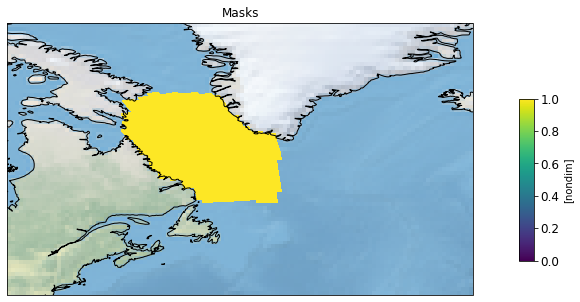

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projPC)

pc = ax.pcolormesh(grd.geolon, grd.geolat, masked,
              transform=ccrs.PlateCarree(),vmin=0, vmax=1)

ax.set_title('Masks')
cax = fig.add_axes([0.9, 0.22, 0.02, 0.45])
cbar = plt.colorbar(pc, cax=cax, label='[nondim]')
cbar.ax.tick_params(labelsize=12) 
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
#ax.set_global()
ax.stock_img()
ax.coastlines();
#fname='PNG/lab_sea_mask.png'
#plt.savefig(fname, dpi=150, bbox_inches='tight')

(40.0, 75.0)

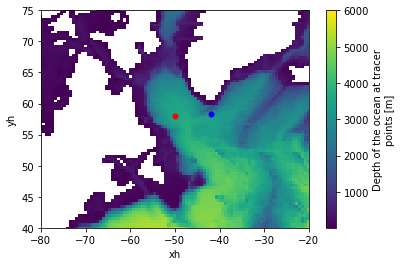

In [23]:
fig, ax = plt.subplots()
grd_xr.depth_ocean.plot(ax=ax)
dummy = grd_xr.depth_ocean.sel(xh = -50, yh = 58., method='nearest')
ax.plot(dummy.xh.values, dummy.yh.values, color='r', ms=5, marker='o');
dummy2 = grd_xr.depth_ocean.sel(xh = -42, yh = 58.5, method='nearest')
ax.plot(dummy2.xh.values, dummy2.yh.values, color='b', ms=5, marker='o');
ax.set_xlim(-80,-20)
ax.set_ylim(40,75)